In [ ]:
import os
import sys
sys.path.append("..")

from PIL import Image
import matplotlib.pyplot as plt
import hydra
import omegaconf
import jax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.serialization import from_bytes
from huggingface_hub import snapshot_download

from src.models.lpn import LPN
from src.models.transformer import EncoderTransformer, DecoderTransformer
from src.datasets.task_gen.task_generator import PatternTaskGenerator
from src.datasets.task_gen.utils import plot_task
from src.visualization import display_grid, ax_to_pil

/Users/clement/lpn/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
repo_id = "clement-bonnet/lpn-2d"
checkpoint_name = "quiet-thunder-789--checkpoint:v0"

local_dir = snapshot_download(repo_id, allow_patterns=f"{checkpoint_name}/*")
print(f"Files downloaded to {local_dir}")
!ls $local_dir/$checkpoint_name

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 16810.84it/s]

Files downloaded to /Users/clement/.cache/huggingface/hub/models--clement-bonnet--lpn-2d/snapshots/3c6f1d76583d5e899d8153d6049bb43b396964dc
config.yaml   state.msgpack



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
with open(f"{local_dir}/{checkpoint_name}/config.yaml", "r") as f:
    cfg = omegaconf.OmegaConf.load(f)

In [4]:
def patch_target(config):
    """Update the _target_ of cfg from src_v2 to src"""
    for key, value in config.items():
        if isinstance(value, omegaconf.DictConfig):
            # Recursive call if the value is another DictConfig
            patch_target(value)
        elif isinstance(value, str) and value.startswith("src_v2"):
            # Update the value if it matches the old_value
            config[key] = value.replace("src_v2", "src")

patch_target(cfg)

In [5]:
encoder = EncoderTransformer(hydra.utils.instantiate(cfg.encoder_transformer))
decoder = DecoderTransformer(hydra.utils.instantiate(cfg.decoder_transformer))
lpn = LPN(encoder=encoder, decoder=decoder)

key = jax.random.PRNGKey(0)
grids = jax.random.randint(
    key, (1, 3, decoder.config.max_rows, decoder.config.max_cols, 2), minval=0, maxval=decoder.config.vocab_size,
)
shapes = jax.random.randint(
    key, (1, 3, 2, 2), minval=1, maxval=min(decoder.config.max_rows, decoder.config.max_cols) + 1,
)
variables = lpn.init(key, grids, shapes, dropout_eval=False, prior_kl_coeff=0.0, pairwise_kl_coeff=0.0, mode="mean")
learning_rate, linear_warmup_steps = 0, 0
linear_warmup_scheduler = optax.warmup_exponential_decay_schedule(
    init_value=learning_rate / (linear_warmup_steps + 1),
    peak_value=learning_rate,
    warmup_steps=linear_warmup_steps,
    transition_steps=1,
    end_value=learning_rate,
    decay_rate=1.0,
)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(linear_warmup_scheduler))
optimizer = optax.MultiSteps(optimizer, every_k_schedule=1)
train_state = TrainState.create(apply_fn=lpn.apply, tx=optimizer, params=variables["params"])

In [6]:
with open(os.path.join(local_dir, checkpoint_name, "state.msgpack"), "rb") as data_file:
    byte_data = data_file.read()
loaded_state = from_bytes(train_state, byte_data)

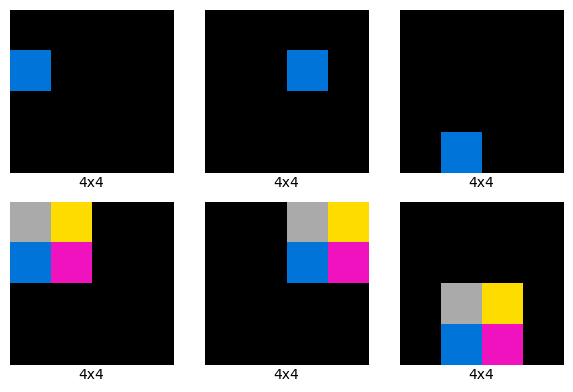

In [7]:
task_gen_1 = PatternTaskGenerator(num_pairs=3, pattern_size=2, num_rows=4, num_cols=4, seed=2)
task_1, _ = next(iter(task_gen_1))
inputs_1 = jnp.stack([pair["input"] for pair in task_1])
outputs_1 = jnp.stack([pair["output"] for pair in task_1])
plot_task(task_1, figsize_factor=2)

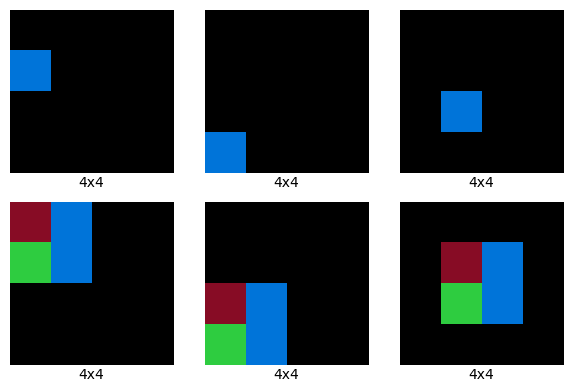

In [ ]:
task_gen_2 = PatternTaskGenerator(num_pairs=3, pattern_size=2, num_rows=4, num_cols=4, seed=7)
task_2, _ = next(iter(task_gen_2))
inputs_2 = jnp.stack([pair["input"] for pair in task_2])
outputs_2 = jnp.stack([pair["output"] for pair in task_2])
plot_task(task_2, figsize_factor=2)

In [9]:
generate_output_from_context = jax.jit(
    lambda context, input, input_grid_shape: lpn.apply(
        {"params": loaded_state.params},
        context=context,
        input=input,
        input_grid_shape=input_grid_shape,
        dropout_eval=True,
        method=lpn._generate_output_from_context,
    )
)

In [12]:
x, y = 0.34, 0.65
blue_location = 1
input = jnp.zeros(16, int).at[blue_location].set(1).reshape(4, 4)
context = jax.scipy.stats.norm.ppf(jnp.array([x, y]))
output_grids, _ = generate_output_from_context(
    context=context[None], input=input[None], input_grid_shape=jnp.array([4, 4])[None]
)
output_grid = output_grids[0]
output_grid

Array([[0, 6, 7, 0],
       [0, 2, 8, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

## Log prob map

In [15]:
import numpy as np
from scipy.stats import norm

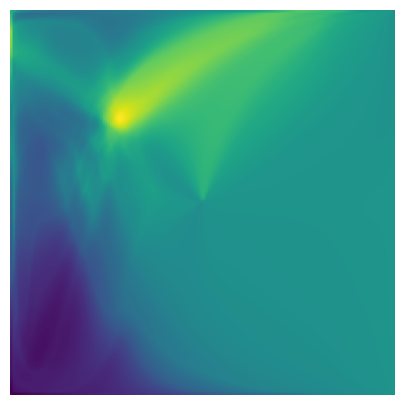

In [28]:
pairs = jnp.stack([inputs_1, outputs_1], axis=-1)
grid_shapes = jnp.full((pairs.shape[0], 2, 2), 4)

@jax.jit
def log_prob_other_pairs(context):
    input_seq, output_seq = lpn._flatten_input_output_for_decoding(pairs[:-1], grid_shapes[:-1])
    row_logits, col_logits, grid_logits = lpn.decoder.apply(
        {"params": loaded_state.params["decoder"]},
        input_seq=input_seq,
        output_seq=output_seq,
        context=context[..., None, :].repeat(output_seq.shape[-2], axis=-2),
        dropout_eval=True,
    )
    log_probs = lpn._compute_log_probs(row_logits, col_logits, grid_logits, output_seq)
    return log_probs

resolution_x, resolution_y = 150, 150
eps = 1e-3

image = np.empty((resolution_y, resolution_x), float)

# Create uniformly spaced grid for plotting
uniform_x = np.linspace(eps, 1-eps, resolution_x)
uniform_y = np.linspace(eps, 1-eps, resolution_y)
X, Y = np.meshgrid(uniform_x, uniform_y)

# Create transformed grid for function evaluation
grid_x = norm.ppf(uniform_x).astype(np.float32)
grid_y = norm.ppf(uniform_y).astype(np.float32)

for col, xi in enumerate(grid_x):
    for row, yj in enumerate(grid_y):
        image[row, col] = log_prob_other_pairs(jnp.array([xi, yj]))

pdf_x = norm.pdf(grid_x)
pdf_y = norm.pdf(grid_y)
XX, YY = np.meshgrid(pdf_x, pdf_y)

plt.figure(figsize=(5, 5))
plt.imshow(image, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.axis("off")
plt.savefig("heatmap_0.png", pad_inches=0, bbox_inches="tight")
plt.show()

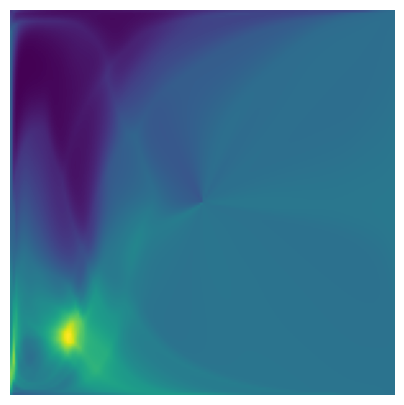

In [27]:
pairs = jnp.stack([inputs_2, outputs_2], axis=-1)
grid_shapes = jnp.full((pairs.shape[0], 2, 2), 4)

@jax.jit
def log_prob_other_pairs(context):
    input_seq, output_seq = lpn._flatten_input_output_for_decoding(pairs[:-1], grid_shapes[:-1])
    row_logits, col_logits, grid_logits = lpn.decoder.apply(
        {"params": loaded_state.params["decoder"]},
        input_seq=input_seq,
        output_seq=output_seq,
        context=context[..., None, :].repeat(output_seq.shape[-2], axis=-2),
        dropout_eval=True,
    )
    log_probs = lpn._compute_log_probs(row_logits, col_logits, grid_logits, output_seq)
    return log_probs

resolution_x, resolution_y = 150, 150
eps = 1e-3

image = np.empty((resolution_y, resolution_x), float)

# Create uniformly spaced grid for plotting
uniform_x = np.linspace(eps, 1-eps, resolution_x)
uniform_y = np.linspace(eps, 1-eps, resolution_y)
X, Y = np.meshgrid(uniform_x, uniform_y)

# Create transformed grid for function evaluation
grid_x = norm.ppf(uniform_x).astype(np.float32)
grid_y = norm.ppf(uniform_y).astype(np.float32)

for col, xi in enumerate(grid_x):
    for row, yj in enumerate(grid_y):
        image[row, col] = log_prob_other_pairs(jnp.array([xi, yj]))

pdf_x = norm.pdf(grid_x)
pdf_y = norm.pdf(grid_y)
XX, YY = np.meshgrid(pdf_x, pdf_y)

plt.figure(figsize=(5, 5))
plt.imshow(image, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.axis("off")
plt.savefig("heatmap_1.png", pad_inches=0, bbox_inches="tight")
plt.show()